# Estimated number of people (all ages) living with HIV

<a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimated-number-of-people--living-with-hiv#:~:text=Situation%20and%20trends%20In%202022,%E2%80%9331.2%20million%5D%20in%202000.">https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimated-number-of-people--living-with-hiv#:~:text=Situation%20and%20trends%20In%202022,%E2%80%9331.2%20million%5D%20in%202000.</a>

<h2>Library</h2>

In [56]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import warnings

warnings.filterwarnings('ignore')

<h2>Function</h2>

In [57]:
# Function to format y-axis labels in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

<h2>Main</h2>

In [58]:
# Import the necessary library
url = "https://ghoapi.azureedge.net/api/HIV_0000000001"

# Send an HTTP GET request to the specified URL
response = requests.get(url)

# Parse the response content as JSON and store it in the 'data' variable
data = response.json()

countries = []
years = []
rates = []

# Iterate through each item in the 'value' field of the JSON data
for item in data['value']:
    countries.append(item['SpatialDim'])
    years.append(item['TimeDim'])
    rates.append(item['NumericValue'])

item

{'Id': 32234927,
 'IndicatorCode': 'HIV_0000000001',
 'SpatialDimType': 'COUNTRY',
 'SpatialDim': 'ZWE',
 'TimeDimType': 'YEAR',
 'TimeDim': 2000,
 'Dim1Type': None,
 'Dim1': None,
 'Dim2Type': None,
 'Dim2': None,
 'Dim3Type': None,
 'Dim3': None,
 'DataSourceDimType': None,
 'DataSourceDim': None,
 'Value': '1 600 000 [1 400 000–1 700 000]',
 'NumericValue': 1600000.0,
 'Low': 1400000.0,
 'High': 1700000.0,
 'Comments': None,
 'Date': '2023-07-11T08:55:11.16+02:00',
 'TimeDimensionValue': '2000',
 'TimeDimensionBegin': '2000-01-01T00:00:00+01:00',
 'TimeDimensionEnd': '2000-12-31T00:00:00+01:00'}

In [59]:
# Create dictionary with JSON data
data = {'Country':countries, 'Year':years, 'Rate': rates}

# Create dataframe from dictionary
df = pd.DataFrame(data)

# Remove regional totals
to_remove = ['GLOBAL','SEAR','AMR','EUR','EMR','AFR','WPR','PAHO']

# Create dataframe without reginal totals
initial_df = df[~df['Country'].isin(to_remove)]

# Remove NAs
initial_df.fillna(0, inplace=True)

initial_df.head()

Country  Year      Rate
231     AFG  2022   12000.0
232     ALB  2022    1500.0
233     DZA  2022   28000.0
234     AND  2022       0.0
235     AGO  2022  310000.0

In [60]:
max_year = initial_df['Year'].max()

In [61]:
# Create dataframe grouped by Year
grouped_year_df = initial_df.groupby(['Year'])['Rate'].sum().reset_index()

grouped_year_df.head()

Year        Rate
0  2000  19789760.0
1  2001  20353180.0
2  2002  20955840.0
3  2003  21293000.0
4  2004  21641160.0

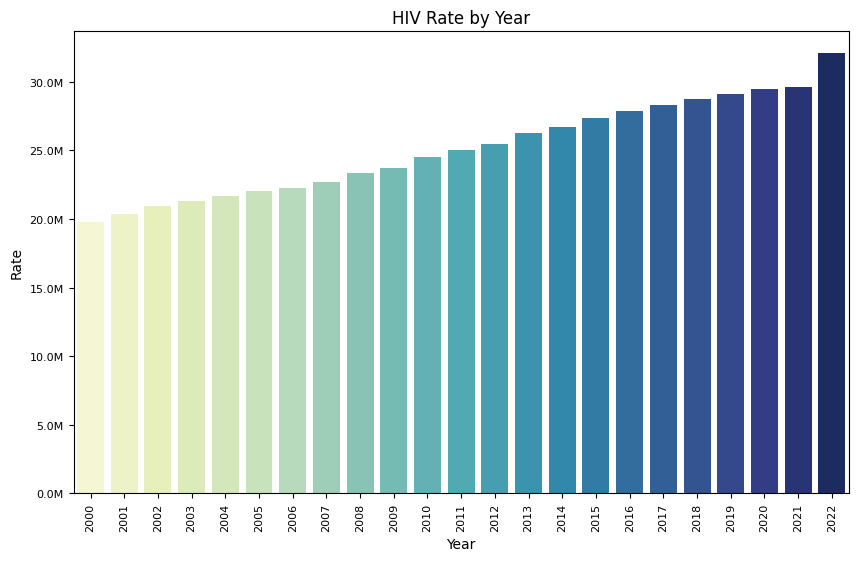

In [62]:
# Create Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_year_df.Year, y=grouped_year_df.Rate, palette='YlGnBu')

plt.title('HIV Rate by Year')
plt.xlabel('Year')
plt.ylabel('Rate')

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# Apply the custom formatter to the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.show()

In [63]:
# Create dataframe grouped by Country from the latest year
grouped_country_df = initial_df[initial_df['Year'] == max_year].groupby(['Country'])['Rate'].sum().sort_values(ascending=False).head(30).reset_index()

grouped_country_df.head()

Country       Rate
0     ZAF  7600000.0
1     IND  2500000.0
2     MOZ  2400000.0
3     TZA  1700000.0
4     ZMB  1400000.0

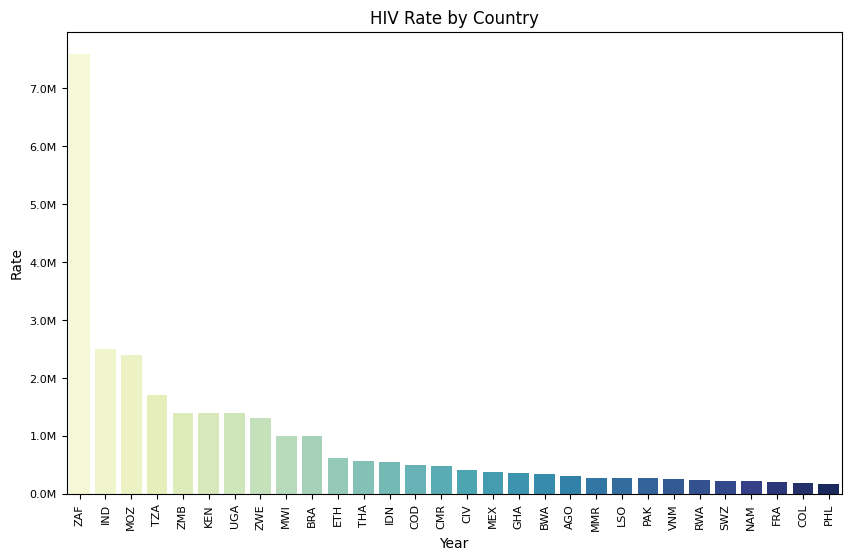

In [64]:
# Create Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_country_df.Country, y=grouped_country_df.Rate, palette='YlGnBu')

plt.title('HIV Rate by Country')
plt.xlabel('Year')
plt.ylabel('Rate')

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# Apply the custom formatter to the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.show()


In [65]:
# Create a dataframe with country name and its iso_alpha version
country_codes = px.data.gapminder().query("year == 2007")[["country", "iso_alpha"]]

country_codes.head()

country iso_alpha
11  Afghanistan       AFG
23      Albania       ALB
35      Algeria       DZA
47       Angola       AGO
59    Argentina       ARG

In [66]:
# Create dataframe to merge country codes and initial dataframe
merged_df = pd.merge(grouped_country_df, country_codes, left_on="Country", right_on="iso_alpha")

# Create a choropleth map using Plotly Express (px)
fig = px.choropleth(merged_df
                    , locations="Country"
                    , color="Rate"
                    , hover_name="Country"
                    , projection="natural earth"
                    , color_continuous_scale="YlGnBu")

fig.show()